# Train a scVI model using Lamin

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data using [Lamin](https://lamin.ai/) dataloader.
LaminDB is a database system based on its MappedCollection designed to support efficient storage, management, and querying of scientific data, particularly in machine learning, bioinformatics, and data science applications. It allows for the easy organization, sharing, and querying of complex datasets, such as those involved in research, experiments, or models.
See [here](https://docs.scvi-tools.org/en/stable/user_guide/use_case/custom_dataloaders.html) for more information

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import time

import scanpy as sc
import scvi
from scvi.dataloaders import MappedCollectionDataModule

→ connected lamindb: anonymous/lamindb_collection_scanvi


Well start by init the lamindb backend and read the known PBMC data

In [3]:
# os.system("lamin init --storage ./lamindb_collection")
import lamindb as ln
# ln.setup.init()

In [4]:
pbmc_dataset = scvi.data.pbmc_dataset(
    save_path=".",
    remove_extracted_data=True,
)

INFO     File ./gene_info_pbmc.csv already downloaded                                                              
INFO     File ./pbmc_metadata.pickle already downloaded                                                            
INFO     File ./pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                         
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at ./pbmc8k/filtered_gene_bc_matrices                                             
INFO     File ./pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                         
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at ./pbmc4k/filtered_gene_bc_matrices                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


In [5]:
pbmc_seurat_v4_cite_seq = scvi.data.pbmc_seurat_v4_cite_seq(save_path=".")

INFO     File ./pbmc_seurat_v4.h5ad already downloaded                                                             


### Preprocessing of the data

In this case we read 2 PBMC data so that we will later show the integration power.
We will select the intersection of those 2 datasets gene names, and consolidate cell types names so that they will be alligned

In [6]:
pbmc_seurat_v4_cite_seq.obs["batch"] = pbmc_seurat_v4_cite_seq.obs.Phase

In [7]:
pbmc_seurat_v4_cite_seq.obs["batch"] = pbmc_seurat_v4_cite_seq.obs["batch"].astype("str")
pbmc_dataset.obs["batch"] = pbmc_dataset.obs["batch"].astype("str")

In [8]:
import numpy as np

gene_intersection = np.intersect1d(
    pbmc_dataset.var.gene_symbols.values, pbmc_seurat_v4_cite_seq.var.index.values
)
pbmc_dataset_filtered = pbmc_dataset[:, pbmc_dataset.var["gene_symbols"].isin(gene_intersection)]
pbmc_seurat_v4_cite_seq_filtered = pbmc_seurat_v4_cite_seq[
    :, pbmc_seurat_v4_cite_seq.var_names.isin(gene_intersection)
]

In [9]:
pbmc_dataset_filtered.var_names = pbmc_dataset_filtered.var["gene_symbols"].values

In [10]:
pbmc_dataset_filtered.obs["cell_type"] = pbmc_dataset_filtered.obs["str_labels"].astype("str")
pbmc_dataset_filtered.obs.loc[
    pbmc_dataset_filtered.obs["cell_type"] == "FCGR3A+ Monocytes", "cell_type"
] = "Monocytes"
pbmc_dataset_filtered.obs.loc[
    pbmc_dataset_filtered.obs["cell_type"] == "CD14+ Monocytes", "cell_type"
] = "Monocytes"
pbmc_dataset_filtered.obs.loc[
    pbmc_dataset_filtered.obs["cell_type"] == "Megakaryocytes", "cell_type"
] = "Other"

In [11]:
pbmc_dataset_filtered

AnnData object with n_obs × n_vars = 11990 × 3315
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts'
    uns: 'cell_types'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc'

The list of different cell types for the first dataaset can be seen 

In [12]:
pbmc_dataset_filtered.obs["cell_type"].value_counts()

cell_type
CD4 T cells        4996
Monocytes          2578
B cells            1621
CD8 T cells        1448
Other               551
NK cells            457
Dendritic Cells     339
Name: count, dtype: int64

We will repeat for the other dataset

In [13]:
pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] = pbmc_seurat_v4_cite_seq_filtered.obs[
    "celltype.l1"
].astype("str")
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "other", "cell_type"
] = "Other"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "B", "cell_type"
] = "B cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "DC", "cell_type"
] = "Dendritic Cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "NK", "cell_type"
] = "NK cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "CD4 T", "cell_type"
] = "CD4 T cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "CD8 T", "cell_type"
] = "CD8 T cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "Mono", "cell_type"
] = "Monocytes"

/tmp/ipykernel_390973/3888762861.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pbmc_seurat_v4_cite_seq_filtered.obs['cell_type'] = pbmc_seurat_v4_cite_seq_filtered.obs['celltype.l1'].astype("str")


In [14]:
pbmc_seurat_v4_cite_seq_filtered

AnnData object with n_obs × n_vars = 152094 × 3315
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size', 'batch', 'cell_type'
    var: 'mt'
    obsm: 'protein_counts'

In [15]:
pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"].value_counts()

cell_type
Monocytes          47217
CD4 T cells        40245
CD8 T cells        24399
NK cells           15384
B cells            13192
other T             5828
Dendritic Cells     3488
Other               2341
Name: count, dtype: int64

In the next part we are creating artifacts from those adata's and unite them to a collection.
Artifacts and collections are the ways lamindb interactes with the data.
From this point forward we will not use adatas again.

In [16]:
ln.track()

→ created Transform('hUtoQ4gffICo0000'), started new Run('miLp7BSR...') at 2025-05-08 09:03:42 UTC


In [17]:
artifact1 = ln.Artifact.from_anndata(pbmc_dataset_filtered, key="part_one1.h5ad").save()
artifact2 = ln.Artifact.from_anndata(pbmc_seurat_v4_cite_seq_filtered, key="part_two1.h5ad").save()

collection = ln.Collection([artifact1, artifact2], key="gather")
collection.save()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Collection(uid='WYhawczHOi6K1dYG0004', is_latest=True, key='gather', hash='wPM0DpO-bWnuNH5Kqd1zEA', space_id=1, created_by_id=1, run_id=1, created_at=2025-05-08 09:03:45 UTC)

In [18]:
# We load the collection to see it consists of many h5ad files
artifacts = collection.artifacts.all()
artifacts.df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
9,cq4K7ESTSPnef6Ol0000,part_one1.h5ad,None,.h5ad,dataset,AnnData,49787918,Qa1fqQcaprCKNBrFOF1l1g,None,11990,md5,True,False,1,1,None,None,True,1,2025-05-08 09:03:44.063000+00:00,1,None,1
10,0DZgfpOHWcVI3tgI0000,part_two1.h5ad,None,.h5ad,dataset,AnnData,998889103,DozCh58Pwbgf9-wzsb976e,None,152094,sha1-fl,True,False,1,1,None,None,True,1,2025-05-08 09:03:44.913000+00:00,1,None,1


we can now define the batch and data loader which replaces the default AnnDataloder of SCVI.

In [19]:
batch_keys = "batch"
datamodule = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    batch_size=1024,
    shuffle=True,
    join="inner",
)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [20]:
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

164084 3315 5


From here we continue like always, define the model (with the registry and not AnnDataManager ) and train it

In [22]:
# Init the model
model = scvi.model.SCVI(registry=datamodule.registry)

In [23]:
# Training the model
import gc

gc.collect()
start = time.time()
model.train(
    max_epochs=100,
    batch_size=1024,
    plan_kwargs={"lr": 0.003, "compile": False},
    early_stopping=False,
    datamodule=datamodule.inference_dataloader(),
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4096. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 244. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 485.27 seconds


In [24]:
model.history["elbo_train"].tail()

,elbo_train
epoch,
95,1853.080566
96,1852.66333
97,1852.367554
98,1852.291748
99,1852.092651


In [25]:
# Save the model
model.save("lamin_model", save_anndata=False, overwrite=True, datamodule=datamodule)

In [26]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [27]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_dataloader = datamodule.inference_dataloader()
latent = model.get_latent_representation(dataloader=inference_dataloader)

In [28]:
# We extract the adata of the model, to be able to use it for plot umaps
# To save time we could also select a sub set of it
adata = collection.load(join="inner")

In [29]:
adata.obsm["scvi"] = latent

In [31]:
adata.obs

,batch,cell_type,artifact_uid
AAACCTGAGCTAGTGG-1,0,CD4 T cells,cq4K7ESTSPnef6Ol0000
AAACCTGCACATTAGC-1,0,CD4 T cells,cq4K7ESTSPnef6Ol0000
AAACCTGCACTGTTAG-1,0,Monocytes,cq4K7ESTSPnef6Ol0000
AAACCTGCATAGTAAG-1,0,Monocytes,cq4K7ESTSPnef6Ol0000
AAACCTGCATGAACCT-1,0,CD8 T cells,cq4K7ESTSPnef6Ol0000
...,...,...,...
E2L8_TTTGTTGGTCGTGATT,S,CD8 T cells,0DZgfpOHWcVI3tgI0000
E2L8_TTTGTTGGTGTGCCTG,G1,Monocytes,0DZgfpOHWcVI3tgI0000
E2L8_TTTGTTGGTTAGTTCG,S,B cells,0DZgfpOHWcVI3tgI0000
E2L8_TTTGTTGGTTGGCTAT,G1,Monocytes,0DZgfpOHWcVI3tgI0000


In [32]:
# We can now generate the neighbors and the UMAP.
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")

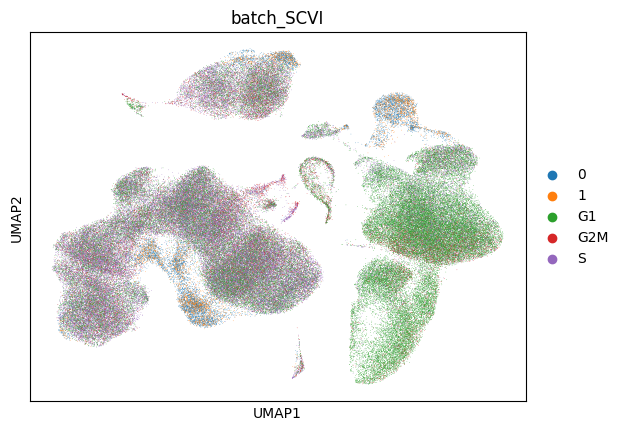

In [33]:
sc.pl.umap(adata, color=batch_keys, title="batch_SCVI")

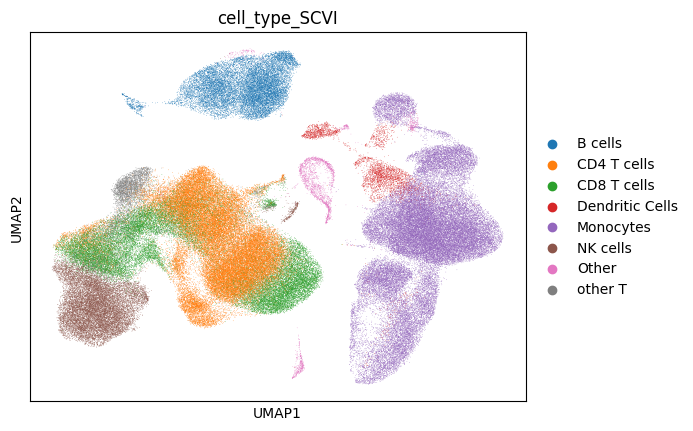

In [34]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCVI")

## scanvi

We will repeat the process just did for SCVI to run a SCANVI model

In [35]:
labels_keys = "cell_type"
datamodule_scanvi = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    label_key=labels_keys,
    batch_size=1024,
    shuffle=True,
    model_name="SCANVI",
    join="inner",
)

164084 3315 5 9


In [ ]:
print(
    datamodule_scanvi.n_obs,
    datamodule_scanvi.n_vars,
    datamodule_scanvi.n_batch,
    datamodule_scanvi.n_labels,
)

In [36]:
# We can now create the scanVI model object and train it:
datamodule_scanvi.setup(stage="train")
model_scanvi = scvi.model.SCANVI(
    adata=None,
    registry=datamodule_scanvi.registry,
    datamodule=datamodule_scanvi,
)

In [38]:
# Training the model
import gc

gc.collect()
start3 = time.time()
model_scanvi.train(
    max_epochs=20,
    batch_size=1024,
    plan_kwargs={"lr": 0.01, "compile": False},
    early_stopping=False,
    n_samples_per_label=100,
    datamodule=datamodule_scanvi,
)
end3 = time.time()
print(f"Elapsed time: {end3 - start3:.2f} seconds")

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Elapsed time: 135.02 seconds


In [39]:
# Save the model
model_scanvi.save(
    "lamin_scanvi_model", save_anndata=False, overwrite=True, datamodule=datamodule_scanvi
)

In [41]:
model_scanvi.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_classification_loss', 'train_accuracy', 'train_f1_score', 'train_calibration_error'])

In [42]:
model_scanvi.history["train_accuracy"].tail()

,train_accuracy
epoch,
15,0.993022
16,0.993101
17,0.993912
18,0.993973
19,0.994369


In [43]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_scanvi_dataloader = datamodule_scanvi.inference_dataloader()
latent_scanvi = model_scanvi.get_latent_representation(dataloader=inference_scanvi_dataloader)

In [44]:
adata.obsm["scanvi"] = latent_scanvi

In [45]:
# We can now generate the neighbors and the UMAP.
sc.pp.neighbors(adata, use_rep="scanvi", key_added="scanvi")
sc.tl.umap(adata, neighbors_key="scanvi")

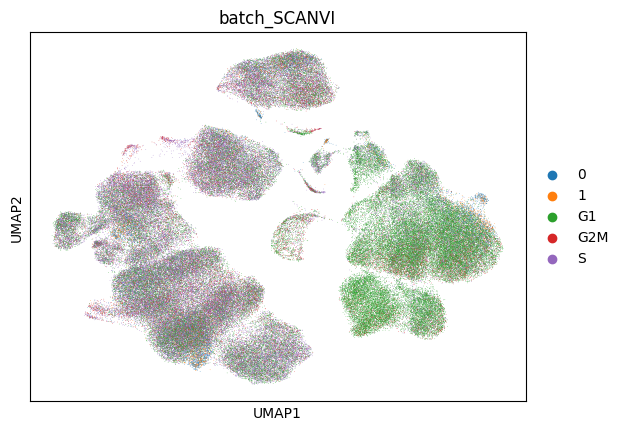

In [46]:
sc.pl.umap(adata, color=batch_keys, title="batch_SCANVI")

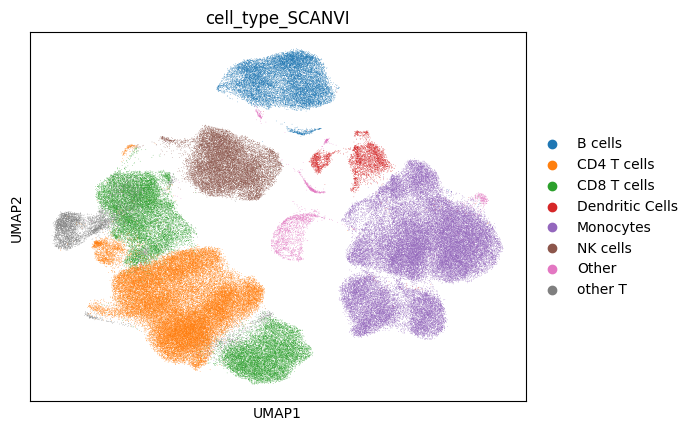

In [47]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCANVI")

Beucase its a scanvi model we can also produce the cell type predictions now

In [48]:
adata.obs["predictions_scanvi"] = model_scanvi.predict(
    dataloader=inference_scanvi_dataloader, batch_size=1024
)

/tmp/ipykernel_390973/1595341984.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(["cell_type", "predictions_scanvi"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

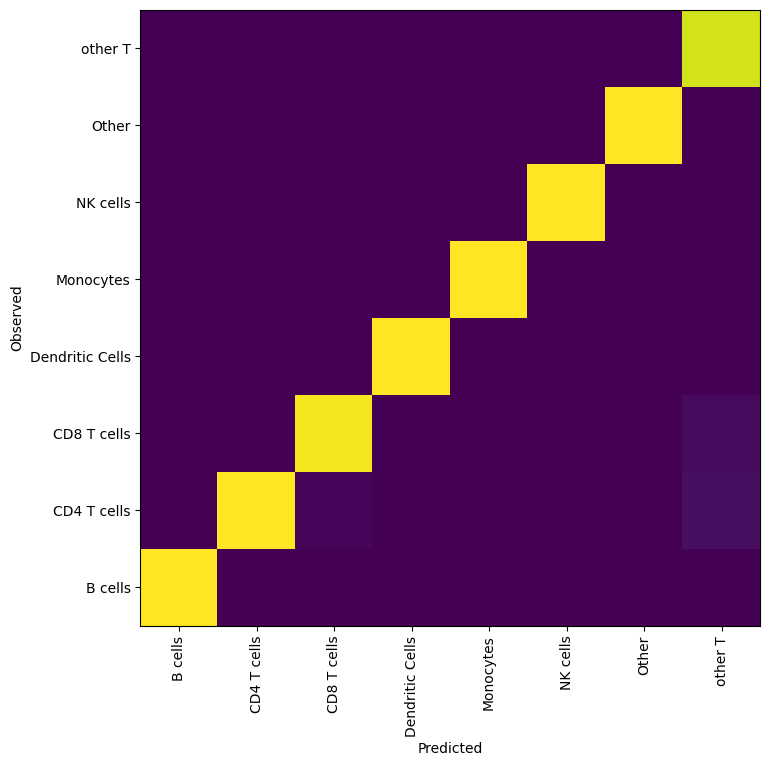

In [51]:
df = adata.obs.groupby(["cell_type", "predictions_scanvi"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Run regulary using adata and compare

We will use the adata we already extracted and train an SCVI and SCANVI models under the 
same conditions as was done for Lamin, in order to compare the results

In [52]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [54]:
adata.obs

,batch,cell_type,artifact_uid,predictions_scanvi
AAACCTGAGCTAGTGG-1,0,CD4 T cells,cq4K7ESTSPnef6Ol0000,CD4 T cells
AAACCTGCACATTAGC-1,0,CD4 T cells,cq4K7ESTSPnef6Ol0000,CD4 T cells
AAACCTGCACTGTTAG-1,0,Monocytes,cq4K7ESTSPnef6Ol0000,Monocytes
AAACCTGCATAGTAAG-1,0,Monocytes,cq4K7ESTSPnef6Ol0000,Monocytes
AAACCTGCATGAACCT-1,0,CD8 T cells,cq4K7ESTSPnef6Ol0000,CD8 T cells
...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,S,CD8 T cells,0DZgfpOHWcVI3tgI0000,CD8 T cells
E2L8_TTTGTTGGTGTGCCTG,G1,Monocytes,0DZgfpOHWcVI3tgI0000,Monocytes
E2L8_TTTGTTGGTTAGTTCG,S,B cells,0DZgfpOHWcVI3tgI0000,B cells
E2L8_TTTGTTGGTTGGCTAT,G1,Monocytes,0DZgfpOHWcVI3tgI0000,Monocytes


In [55]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", layer="counts")

In [56]:
# model_census3 = scvi.model.SCVI.load("census_model", adata=adata)
model_census3 = scvi.model.SCVI(adata)

In [57]:
start2 = time.time()
model_census3.train(
    max_epochs=100,
)
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 548.92 seconds


We can see that under same conditions, lamin training was faster by about 10% than using the AnnDataLoader

In [58]:
model_census3.history["elbo_train"].tail()

,elbo_train
epoch,
95,1828.02417
96,1827.902954
97,1827.885864
98,1827.774658
99,1827.692383


In [59]:
adata.obsm["scvi_non_dataloder"] = model_census3.get_latent_representation()

In [60]:
sc.pp.neighbors(adata, use_rep="scvi_non_dataloder", key_added="scvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scvi_non_dataloder")

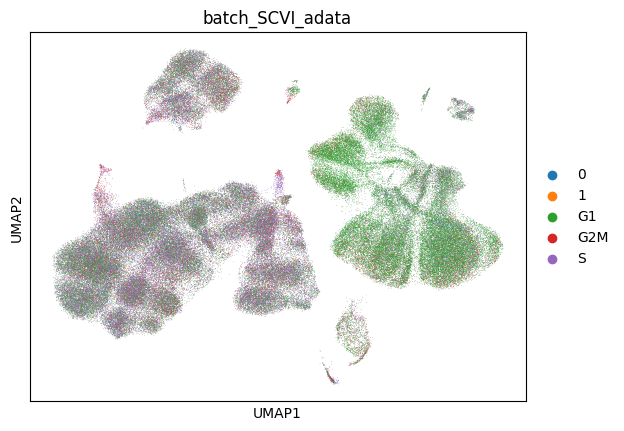

In [61]:
sc.pl.umap(adata, color="batch", title="batch_SCVI_adata")

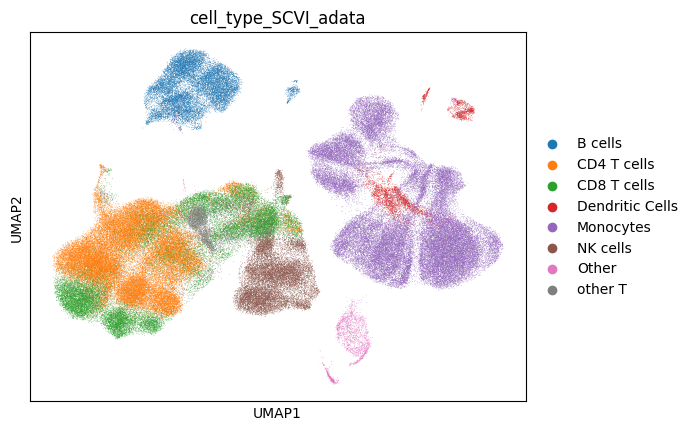

In [62]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCVI_adata")

## scanvi (regular)

In [63]:
adata

AnnData object with n_obs × n_vars = 164084 × 3315
    obs: 'batch', 'cell_type', 'artifact_uid', 'predictions_scanvi', '_scvi_batch', '_scvi_labels'
    uns: 'scvi', 'umap', 'batch_colors', 'cell_type_colors', 'scanvi', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'scvi_non_dataloder'
    obsm: 'scvi', 'X_umap', 'scanvi', 'scvi_non_dataloder'
    layers: 'counts'
    obsp: 'scvi_distances', 'scvi_connectivities', 'scanvi_distances', 'scanvi_connectivities', 'scvi_non_dataloder_distances', 'scvi_non_dataloder_connectivities'

In [64]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    labels_key="cell_type",
    unlabeled_category="label_0",
    batch_key=batch_keys,
)

In [65]:
# model_census4 = scvi.model.SCVI.load("census_model", adata=adata)
model_census4 = scvi.model.SCANVI(adata)

In [66]:
start4 = time.time()
model_census4.train(
    max_epochs=100,
)
end4 = time.time()
print(f"Elapsed time: {end4 - start4:.2f} seconds")

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 1110.17 seconds


In [67]:
model_census4.history["train_accuracy"].tail()

,train_accuracy
epoch,
95,0.99784
96,0.997176
97,0.997765
98,0.99765
99,0.997522


In [68]:
adata.obsm["scanvi_non_dataloder"] = model_census4.get_latent_representation()

In [69]:
sc.pp.neighbors(adata, use_rep="scanvi_non_dataloder", key_added="scanvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scanvi_non_dataloder")

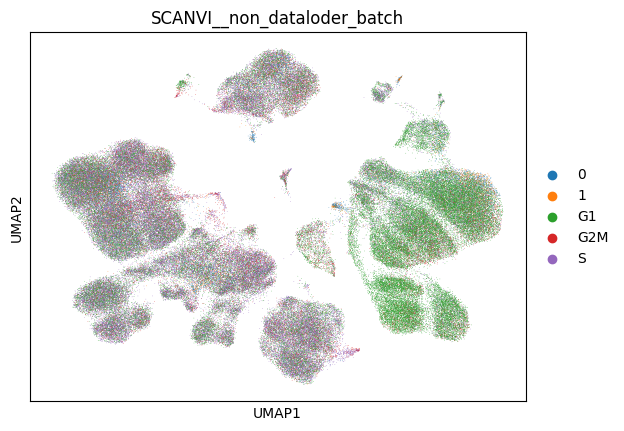

In [70]:
sc.pl.umap(adata, color=["batch"], title=["SCANVI__non_dataloder_" + x for x in ["batch"]])

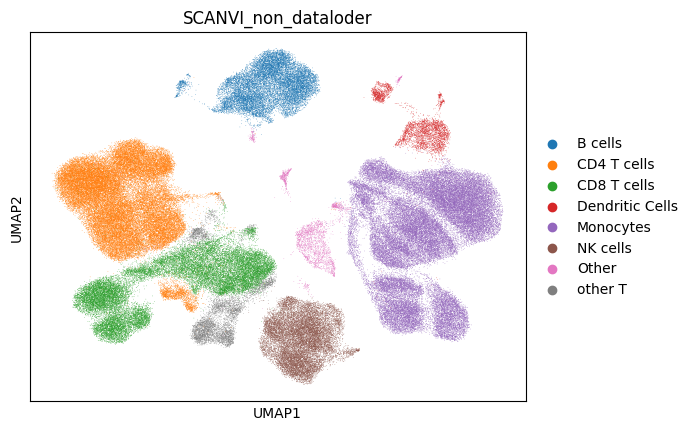

In [71]:
sc.pl.umap(adata, color="cell_type", title="SCANVI_non_dataloder")

In [72]:
adata.obs["predictions_scanvi_non_dataloder"] = model_census4.predict()

/tmp/ipykernel_390973/704304115.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(["cell_type", "predictions_scanvi_non_dataloder"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

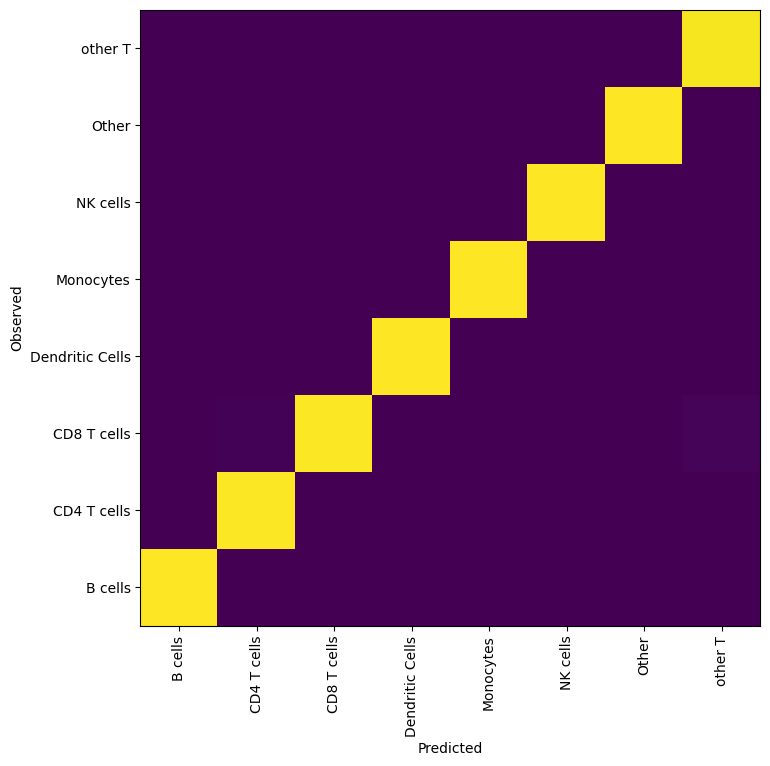

In [73]:
df = (
    adata.obs.groupby(["cell_type", "predictions_scanvi_non_dataloder"])
    .size()
    .unstack(fill_value=0)
)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Compare results

Compute integration metrics

In [74]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scvi", "scanvi", "scvi_non_dataloder", "scanvi_non_dataloder"],
    n_jobs=-1,
)
bm.benchmark()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:16<00:08,  2.21s/it, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:18<00:05,  1.89s/it, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  20%|███████████████████████▊                                                                                               | 1/5 [00:18<01:14, 18.69s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.21it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  40%|███████████████████████████████████████████████▌                                                                       | 2/5 [00:25<00:35, 11.96s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.40it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  60%|███████████████████████████████████████████████████████████████████████▍                                               | 3/5 [00:32<00:18,  9.38s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.38it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4/5 [00:38<00:08,  8.18s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.39it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.99s/it]

                                                                                                                                                                   

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


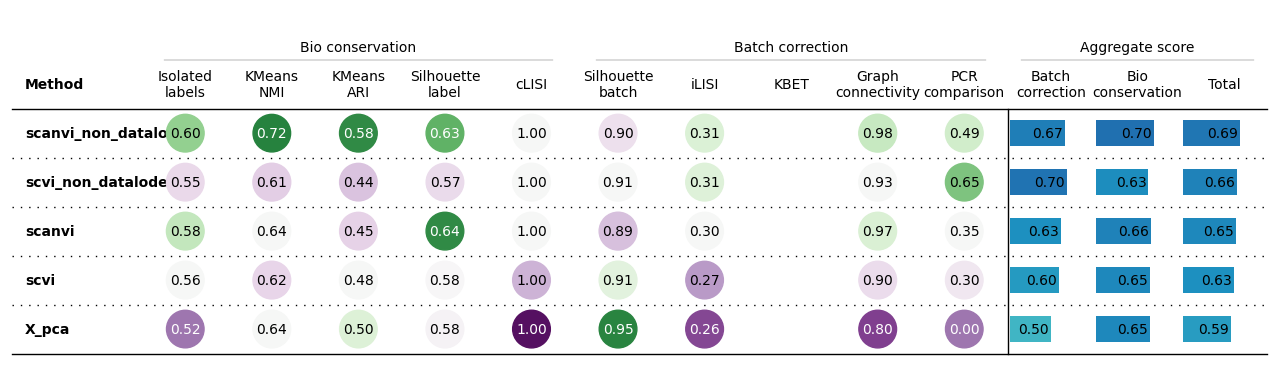

In [1]:
bm.plot_results_table(min_max_scale=False)

As expected SCANVI outperforms the SCVI using the labels data, 
however as can be seen the regular use of Anndataloader dataloader
gives 5% better integration results comparing to the lamin dataloader